In [1]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import mip
from copy import deepcopy

def save_dict(data, name):
    with open(name, 'w' ) as file:
        json.dump( data, file )

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [2]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.28236539253226034
Growth:  2.5586946126133867


In [3]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [4]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [5]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

In [6]:
from community_models import *

In [7]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())

model_DP.medium = compm_DP 
model_SA.medium = compm_SA

In [8]:
model1 = Model(model_DP, BIOMASS_DP)
model2 = Model(model_SA, BIOMASS_SA)

community_model1 = model1 + model2 

In [9]:
community_model2 = MIP_community_model(model1, model2)

In [10]:
community_model3_1_1 = create_bag_of_react_model([model_DP, model_SA],[BIOMASS_DP, BIOMASS_SA], [1,1])
community_model3_10_1 = create_bag_of_react_model([model_DP, model_SA],[BIOMASS_DP, BIOMASS_SA], [10,1])

Ignoring reaction 'ACALD' since it already exists.
Ignoring reaction 'ACALDt' since it already exists.
Ignoring reaction '3OAS140' since it already exists.
Ignoring reaction '3OAS60' since it already exists.
Ignoring reaction 'ACCOAC' since it already exists.
Ignoring reaction '5DOAN' since it already exists.
Ignoring reaction '6PHBG' since it already exists.
Ignoring reaction '6PHBG2' since it already exists.
Ignoring reaction 'ACGS' since it already exists.
Ignoring reaction 'ACKr' since it already exists.
Ignoring reaction '3HAD100' since it already exists.
Ignoring reaction '3HAD120' since it already exists.
Ignoring reaction '3HAD140' since it already exists.
Ignoring reaction 'ACACT1r' since it already exists.
Ignoring reaction '3HAD60' since it already exists.
Ignoring reaction 'ACM6PH' since it already exists.
Ignoring reaction '3OAR100' since it already exists.
Ignoring reaction '3OAR140' since it already exists.
Ignoring reaction '3OAR60' since it already exists.
Ignoring rea

In [14]:
community_model1.set_weights([1,1])
print("MBR Weights 1:1: ", community_model1.slim_optimize())
single_growth = community_model1.optimize().x[community_model1.objective_c != 0]
print("DP growth: ", single_growth[0])
print("SA growth: ", single_growth[1])
community_model1.set_weights([10,1])
print("MBR Weights 10:1: ", community_model1.slim_optimize())
single_growth = community_model1.optimize().x[community_model1.objective_c != 0]
print("DP growth: ", single_growth[0])
print("SA growth: ", single_growth[1])

MBR Weights 1:1:  2.558694612608908
DP growth:  -4.679449020693844e-12
SA growth:  2.5586946126135874
MBR Weights 10:1:  2.9045218796909653
DP growth:  0.07290151281797515
SA growth:  2.1755067515112136


In [15]:
community_model2.weights = [1,1]
print("MBR Weights 1:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)
community_model2.weights = [10,1]
print("MBR Weights 10:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)

MBR Weights 1:1:  2.558694612608013
SA growth:  2.5586946126067533
DP growth:  1.2596206122997742e-12
MBR Weights 10:1:  2.9045218796909653
SA growth:  2.175506751511213
DP growth:  0.0729015128179752


In [16]:
print("MBR Weights 1:1: ", community_model3_1_1.slim_optimize())
print("SA growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_DP).flux))
print("MBR Weights 10:1: ", community_model3_10_1.slim_optimize())
print("SA growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_DP).flux))

MBR Weights 1:1:  2.558694612705676
SA growth: 2.558694612734215
DP growth: -2.8539162925648968e-11
MBR Weights 10:1:  2.9045218796909635
SA growth: 2.1755067515112225
DP growth: 0.07290151281797412


In [17]:
coopm = community_model2.compute_coopm()
coopm2 = optimize_coopm_community(community_model3_1_1, community_model3_1_1.slim_optimize(), [BIOMASS_DP, BIOMASS_SA], [1,1])

In [19]:
coopm

{'EX_glc__D_e': 5.746981720642888,
 'EX_4abz_e': 1.8817593176694293e-05,
 'EX_cl_e': 0.0031451105499038278,
 'EX_thr__L_e': 0.036136514774758904,
 'EX_k_e': 0.055481726720438156,
 'EX_pro__L_e': 0.006217822150725922,
 'EX_ca2_e': 0.0015098276484246155,
 'EX_mg2_e': 0.004886748996120382,
 'EX_mn2_e': 0.0012925558614843122,
 'EX_cobalt2_e': 0.001026770521430396,
 'EX_zn2_e': 0.0010192218981230695,
 'EX_cu2_e': 0.0009522373161735098,
 'EX_o2_e': 7.376856052262698,
 'EX_fe2_e': 0.006453594204572476,
 'EX_so4_e': 0.0018283165616786784,
 'EX_thm_e': 0.00013581420683153394,
 'EX_cys__L_e': 0.1968042976978547,
 'EX_na1_e': 0.5804867061673419,
 'EX_ni2_e': 0.0010309655343456302,
 'EX_nac_e': 0.0003704532521579851,
 'EX_26dap__M_e': 0.0028127941692003876,
 'EX_mobd_e': 2.0331653157836757e-06}

In [20]:
coopm2

{'EX_cl_e': 0.016302785473123364,
 'EX_arg__L_e': 3.552713678800501e-15,
 'EX_k_e': 0.061146276356333594,
 'EX_ca2_e': 0.013300598274540035,
 'EX_mg2_e': 0.024043860079501277,
 'EX_mn2_e': 0.00987131638492656,
 'EX_cobalt2_e': 0.009045179587176941,
 'EX_zn2_e': 0.008232565782979461,
 'EX_cu2_e': 0.008388590590234104,
 'EX_o2_e': 0.002861492940135712,
 'EX_fe2_e': 0.02286686831387244,
 'EX_so4_e': 0.006604821602657734,
 'EX_thm_e': 0.00016937469269103357,
 'EX_cys__L_e': 10.0,
 'EX_na1_e': 0.532239187962162,
 'EX_ni2_e': 0.00908213491886679,
 'EX_nac_e': 0.0030688309233153337,
 'EX_mobd_e': 1.791086228893973e-06}

In [21]:
community_model2.set_medium(coopm)
community_model2.weights = [1,1]
print("MBR Weights 1:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)
community_model2.weights = [10,1]
print("MBR Weights 10:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)

MBR Weights 1:1:  0.31944228579680517
SA growth:  0.29045481875022927
DP growth:  0.028987467046575892
MBR Weights 10:1:  0.5755915442522821
SA growth:  0.29047649842778606
DP growth:  0.028511504582449602


In [22]:
community_model3_1_1.medium = coopm
print("MBR Weights 1:1: ", community_model3_1_1.slim_optimize())
print("SA growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_DP).flux))
community_model3_10_1.medium = coopm
print("MBR Weights 10:1: ", community_model3_10_1.slim_optimize())
print("SA growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_DP).flux))

MBR Weights 1:1:  0.31949740676623206
SA growth: 0.29045218796934646
DP growth: 0.02904521879688559
MBR Weights 10:1:  0.580904375938417
SA growth: 0.2904521879693519
DP growth: 0.02904521879690651


In [23]:
community_model2.set_medium(coopm2)
community_model2.weights = [1,1]
print("MBR Weights 1:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)
community_model2.weights = [10,1]
print("MBR Weights 10:1: ", community_model2.optimize())
print("SA growth: ", community_model2.x2[community_model2.obj2].x)
print("DP growth: ", community_model2.x1[community_model2.obj1].x)

MBR Weights 1:1:  0.0
SA growth:  0.0
DP growth:  0.0
MBR Weights 10:1:  0.0
SA growth:  0.0
DP growth:  0.0


In [24]:
community_model3_1_1.medium = coopm2
print("MBR Weights 1:1: ", community_model3_1_1.slim_optimize())
print("SA growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_1_1.reactions.get_by_id(BIOMASS_DP).flux))
community_model3_10_1.medium = coopm2
print("MBR Weights 10:1: ", community_model3_10_1.slim_optimize())
print("SA growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_SA).flux))
print("DP growth: " + str(community_model3_10_1.reactions.get_by_id(BIOMASS_DP).flux))

MBR Weights 1:1:  0.5117389225411352
SA growth: 0.2558694612705676
DP growth: 0.2558694612705676
MBR Weights 10:1:  2.8145640739762436
SA growth: 0.2558694612705676
DP growth: 0.2558694612705676


## COOPM alphas model

Here is a collection of COOPM medias for different alpha values

In [26]:
community_model2 = MIP_community_model(model1, model2)

In [27]:
alphas = [0.,0.01,0.1,0.2,0.5,0.8,0.9,0.99,1.]
coopms = []
for alpha in alphas:
    coopms.append(community_model2.compute_alpha_coopm(alpha))

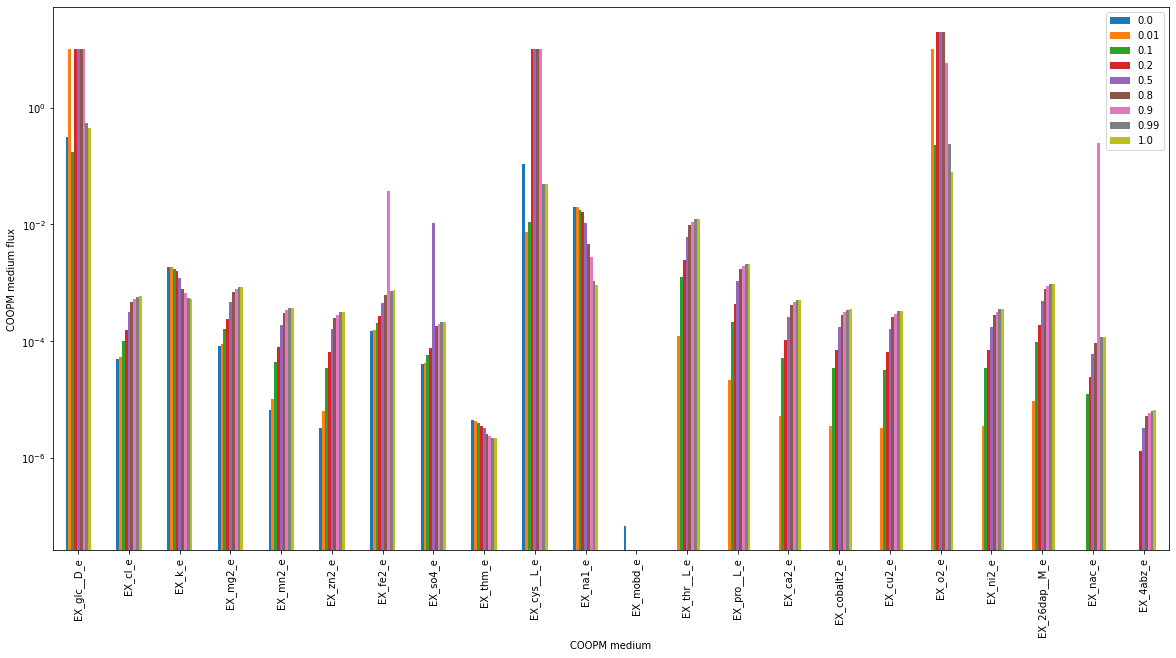

In [29]:
df = pd.DataFrame(coopms)
df.index = alphas
df.T.plot.bar(figsize=(20,10))
plt.yscale("log")
plt.ylabel("COOPM medium flux")
plt.xlabel("COOPM medium")
plt.savefig("COOPM_alpha_plot.pdf")